# Flight price prediction

Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. Flight prices are surely unpredictable. Or are they?

TASK: You have been hired as a Data Scientist for "Mytravelbookings.com". As a data scientist, you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

**Your objective is to predict the flight prices using that data.**

**Data Dictionary**

|Variable|Description|
|---|---|
|Airline|The name of the airline|
|Date_of_Journey|Date on which the journey commenced in dd/mm/yyyy format|
|source|The source from which journey or service begins|
|Destination|The destination where the service ends|
|Route|The route taken by the flight to reach the destination|
|Dep_Time|The time when the journey starts from the source|
|Arrival_Time|Time of arrival at the destination|
|Duration|Total duration of the flight|
|Total_Stops|Total stops between the source and destination|
|Additional_Info|Additional information about the flight|
|Price|Target, The price of the ticket|

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor ,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [2]:
# reading the dataset
data = pd.read_csv('./data/train.csv')
pd.set_option('display.max_columns', None)
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Airline C,12/06/2019,Delhi,Cochin,DEL → MAA → COK,20:40,09:25 13 Jun,12h 45m,1 stop,No info,7480
1,Airline A,18/06/2019,Banglore,Delhi,BLR → DEL,18:55,22:00,3h 5m,non-stop,No info,8016
2,Airline C,18/05/2019,Delhi,Cochin,DEL → BOM → COK,03:50,19:15,15h 25m,1 stop,No info,8879
3,Airline A,6/05/2019,Kolkata,Banglore,CCU → BOM → BLR,20:00,08:15 07 May,12h 15m,1 stop,In-flight meal not included,9663
4,Airline A,9/05/2019,Kolkata,Banglore,CCU → BOM → BLR,06:30,12:00,5h 30m,1 stop,In-flight meal not included,9663


In [3]:
# shape of the dataset
data.shape

(8012, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8012 entries, 0 to 8011
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          8012 non-null   object
 1   Date_of_Journey  8012 non-null   object
 2   Source           8012 non-null   object
 3   Destination      8012 non-null   object
 4   Route            8011 non-null   object
 5   Dep_Time         8012 non-null   object
 6   Arrival_Time     8012 non-null   object
 7   Duration         8012 non-null   object
 8   Total_Stops      8011 non-null   object
 9   Additional_Info  8012 non-null   object
 10  Price            8012 non-null   int64 
dtypes: int64(1), object(10)
memory usage: 688.7+ KB


In [5]:
# checking for missing values
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
# looking at the rows containing missing values
data[data.isnull().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
1807,Airline C,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


Only one value is missing in the Route column and Total_Stops column. We can drop this data entry as it won't make a difference in price prediction.

In [7]:
# dropping missing values
data.dropna(inplace=True)
data.shape

(8011, 11)

In [8]:
# statistical description of the numerical features of the data
data.describe()

,Price
count,8011.000000
mean,9062.235426
std,4626.848090
min,1759.000000
25%,5277.000000
50%,8371.000000
75%,12373.000000
max,79512.000000


In [9]:
# statistical description of the categorical features of the data
data.describe(include = ['O'])

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,8011,8011,8011,8011,8011,8011,8011,8011,8011,8011
unique,12,44,5,6,122,219,1182,353,4,10
top,Airline A,6/06/2019,Delhi,Cochin,DEL → BOM → COK,18:55,19:00,2h 50m,1 stop,No info
freq,2881,390,3397,3397,1784,189,303,412,4235,6250


### Insights:
- The mean price of flight tickets is nearly 9000 and most tickets are under priced 12,400. However, the most expensive ticket is worth 79,512 which implies that the price feature contains outliers.
- The data contains flights information for only 44 different days. We can extract the month, year and date from Date_of_journey to see which affect the price most. 
- Airline A has the highest frequency amongst the 12 airlines.
- Most flights had 1 stop in their route.
- There are 5 source cities and 6 destination cities, with Delhi being the most popular source and cochin being the most popular destination.
- We can perform feature engineering to extract the hour and minutes information from Departure time and Arrival time features to find out the busiest hours and how they affect the price.
- Duration can be converted to minutes to analyse its overall effect on price.

## Feature engineering and data cleaning

### The feature 'Date_of_Journey' can be converted to pandas datetime object.

In [10]:
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], dayfirst=True)

In [11]:
type(data['Date_of_Journey'][0])

pandas._libs.tslibs.timestamps.Timestamp

### We extract the date, month and year of the journey as these individually can help in better prediction of price and we will further see its effect on the target feature.

In [12]:
data['Journey_date']  = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month
data['Journey_year']  = data['Date_of_Journey'].dt.year

In [13]:
data[['Date_of_Journey', 'Journey_date', 'Journey_month', 'Journey_year']].head(20)

,Date_of_Journey,Journey_date,Journey_month,Journey_year
0,2019-06-12,12,6,2019
1,2019-06-18,18,6,2019
2,2019-05-18,18,5,2019
3,2019-05-06,6,5,2019
4,2019-05-09,9,5,2019
5,2019-06-27,27,6,2019
6,2019-06-03,3,6,2019
7,2019-06-24,24,6,2019
8,2019-06-12,12,6,2019
9,2019-06-09,9,6,2019


In [14]:
data.Journey_year.value_counts()

2019    8011
Name: Journey_year, dtype: int64

The dataset contains flight details of the year 2019 only. Hence it won't add any value in the price prediction. So we drop this feature. Also, since we have retrieved the month and date information from Date_of_Journey feature, we can drop this feature too.

In [15]:
data.drop(['Date_of_Journey', 'Journey_year'], axis=1, inplace=True)

### Extracting hour and minutes from departure time and arrival time

In [16]:
def extract_hour_minutes(dataframe, time_feature):
    """ This functions takes in the dataframe and name of the time feature column and extracts the hour and minutes from it.
        Creates two new features in the dataframe containing the hour and minute of the given time of the flight with
        datatype int64 and drops the original time feature.
        
        Parameters:
        -------------
        dataframe : dataframe containing the departure time feature
        time_feature : string containing the column name from dataframe that contains the  time data
        
        Returns:
        -------------
        original dataframe with the new hour and minute features
    """
    
    dataframe[time_feature+'_hour'] = (dataframe[time_feature].apply(lambda x: x.split(':')[0])).astype(np.int64)
    dataframe[time_feature+'_min']  = (dataframe[time_feature].apply(lambda x: x.split(':')[1])).astype(np.int64)
    
    dataframe.drop(time_feature, axis=1, inplace=True)
    
    return dataframe.head()

In [17]:
extract_hour_minutes(data, 'Dep_Time')

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min
0,Airline C,Delhi,Cochin,DEL → MAA → COK,09:25 13 Jun,12h 45m,1 stop,No info,7480,12,6,20,40
1,Airline A,Banglore,Delhi,BLR → DEL,22:00,3h 5m,non-stop,No info,8016,18,6,18,55
2,Airline C,Delhi,Cochin,DEL → BOM → COK,19:15,15h 25m,1 stop,No info,8879,18,5,3,50
3,Airline A,Kolkata,Banglore,CCU → BOM → BLR,08:15 07 May,12h 15m,1 stop,In-flight meal not included,9663,6,5,20,0
4,Airline A,Kolkata,Banglore,CCU → BOM → BLR,12:00,5h 30m,1 stop,In-flight meal not included,9663,9,5,6,30


In [18]:
data['Arrival_Time'] = data['Arrival_Time'].apply(lambda x: x.split(' ')[0])

extract_hour_minutes(data, 'Arrival_Time')

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,Airline C,Delhi,Cochin,DEL → MAA → COK,12h 45m,1 stop,No info,7480,12,6,20,40,9,25
1,Airline A,Banglore,Delhi,BLR → DEL,3h 5m,non-stop,No info,8016,18,6,18,55,22,0
2,Airline C,Delhi,Cochin,DEL → BOM → COK,15h 25m,1 stop,No info,8879,18,5,3,50,19,15
3,Airline A,Kolkata,Banglore,CCU → BOM → BLR,12h 15m,1 stop,In-flight meal not included,9663,6,5,20,0,8,15
4,Airline A,Kolkata,Banglore,CCU → BOM → BLR,5h 30m,1 stop,In-flight meal not included,9663,9,5,6,30,12,0


In [19]:
data.dtypes

Airline              object
Source               object
Destination          object
Route                object
Duration             object
Total_Stops          object
Additional_Info      object
Price                 int64
Journey_date          int64
Journey_month         int64
Dep_Time_hour         int64
Dep_Time_min          int64
Arrival_Time_hour     int64
Arrival_Time_min      int64
dtype: object

### Converting the flight duration to minutes

In [20]:
def convert_duration_to_min(string):
    """
    This function takes a string corresponding to duration, finds numbers from it corresponding to hours and minutes 
    and converts the total duration to minutes.
    
    Paramaters:
    -----------
    string : str type object containing hours and minutes 
    
    Returns:
    -----------
    Converted time in minutes
    """
    numbers = re.findall('\d+',string)
    numbers = list(map(int, numbers))  # extracts all numbers from the string and saves them as integers in a list
    
    #  the code below checks for existence of hour and minutes components and converts the duration into minutes accordingly
    
    if string.find('h') != -1:   # for all the durations containing hour component
        if len(numbers) == 2:
            minutes = numbers[0]*60 + numbers[1]
        else:
            minutes = numbers[0]*60
    else:         # for all the durations that contain only minutes component
        minutes = numbers[0]

    return minutes

In [21]:
data['Duration_in_minutes'] = data.Duration.apply(convert_duration_to_min)
data[['Duration', 'Duration_in_minutes']].head(10)

,Duration,Duration_in_minutes
0,12h 45m,765
1,3h 5m,185
2,15h 25m,925
3,12h 15m,735
4,5h 30m,330
5,2h 40m,160
6,22h,1320
7,2h 30m,150
8,7h 5m,425
9,5h 40m,340


We can now drop the original Duration feature from the data frame.

In [22]:
data.drop('Duration', axis=1, inplace=True)

In [23]:
data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_in_minutes
0,Airline C,Delhi,Cochin,DEL → MAA → COK,1 stop,No info,7480,12,6,20,40,9,25,765
1,Airline A,Banglore,Delhi,BLR → DEL,non-stop,No info,8016,18,6,18,55,22,0,185
2,Airline C,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,8879,18,5,3,50,19,15,925
3,Airline A,Kolkata,Banglore,CCU → BOM → BLR,1 stop,In-flight meal not included,9663,6,5,20,0,8,15,735
4,Airline A,Kolkata,Banglore,CCU → BOM → BLR,1 stop,In-flight meal not included,9663,9,5,6,30,12,0,330


In [24]:
data.describe().Duration_in_minutes

count    8011.000000
mean      640.578579
std       506.392037
min         5.000000
25%       170.000000
50%       510.000000
75%       930.000000
max      2860.000000
Name: Duration_in_minutes, dtype: float64

In [25]:
# the minimum value of duration is 5 min. Checking the details of this flight
data[data['Duration_in_minutes'] == 5]

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_in_minutes
1054,Airline C,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,2 stops,No info,17327,6,3,16,50,16,55,5


The minimum flight duration is 5 minutes which is practically not possible. There can be a mistake in this data entry, possibly in the departure or arrival timing.


In [26]:
# checking categories of Additional info feature
data.Additional_Info.value_counts()

No info                         6250
In-flight meal not included     1492
No check-in baggage included     249
1 Long layover                     9
Business class                     3
No Info                            3
Change airports                    2
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

### Combining two categories of Additional_info feature

We will combine the "No Info" and "No info" categories.

In [27]:
data.Additional_Info = data.Additional_Info.apply(lambda x : x.replace("No Info", "No info"))

In [28]:
data.Additional_Info.value_counts()

No info                         6253
In-flight meal not included     1492
No check-in baggage included     249
1 Long layover                     9
Business class                     3
Change airports                    2
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

### We can combine few more categories of this feature to reduce the categories having just 2 or 3 entries, into the No info category based on their price.

In [29]:
data.Additional_Info = data.Additional_Info.apply(lambda x : x.replace("1 Short layover", "Layover"))
data.Additional_Info = data.Additional_Info.apply(lambda x : x.replace("1 Long layover", "Layover"))
data.Additional_Info = data.Additional_Info.apply(lambda x : x.replace("2 Long layover", "Layover"))

data.Additional_Info = data.Additional_Info.apply(lambda x : x.replace("Red-eye flight", "No info"))
data.Additional_Info = data.Additional_Info.apply(lambda x : x.replace("Change airports", "No info"))

data.Additional_Info.value_counts()

No info                         6256
In-flight meal not included     1492
No check-in baggage included     249
Layover                           11
Business class                     3
Name: Additional_Info, dtype: int64

# Exploratory Data Analysis

Let's now use the existing and newly created features to explore the data and analyze the relationship between various various.

## Distribution of price of flights

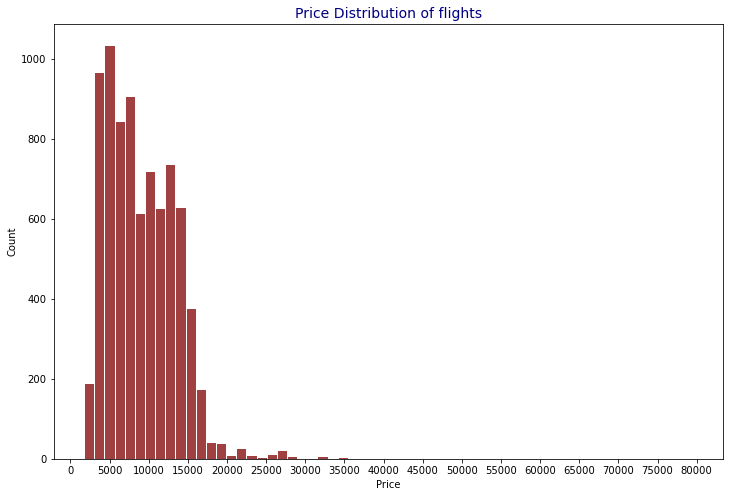

In [30]:
plt.figure(figsize=(12,8))
sns.histplot(x= data.Price, edgecolor="white", bins=60, color="maroon")
plt.title("Price Distribution of flights", size=14, color="navy")
plt.xticks(np.arange(0, 85000, 5000))
plt.show()

### Insights:
- The distribution of price of the flights is postively skewed, meaning that most of the values lie between 2000 to 17000 and there are some extreme values of prices upto 80000


## Analyzing the relation between flight duration and price

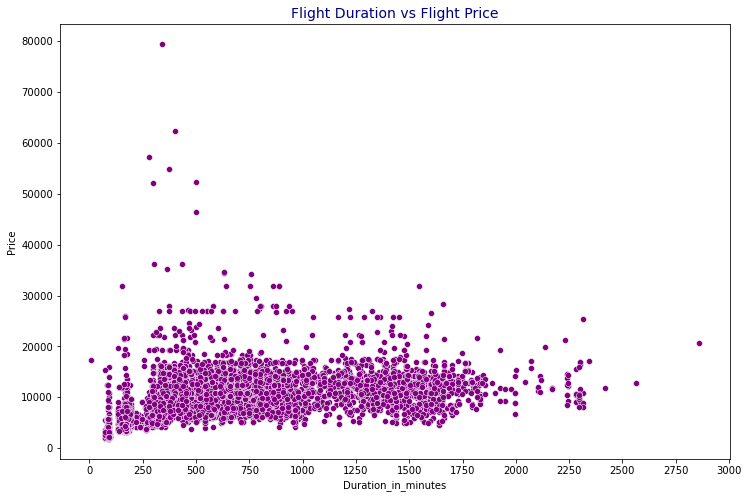

In [31]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=data.Duration_in_minutes, y=data.Price, color='purple')
plt.xticks(np.arange(0,3250,250))
plt.title("Flight Duration vs Flight Price", size=14, color='navy')
plt.show()

### Insights:
- There is some positive correlation between the duration of flight and its price. 

## Airline analysis

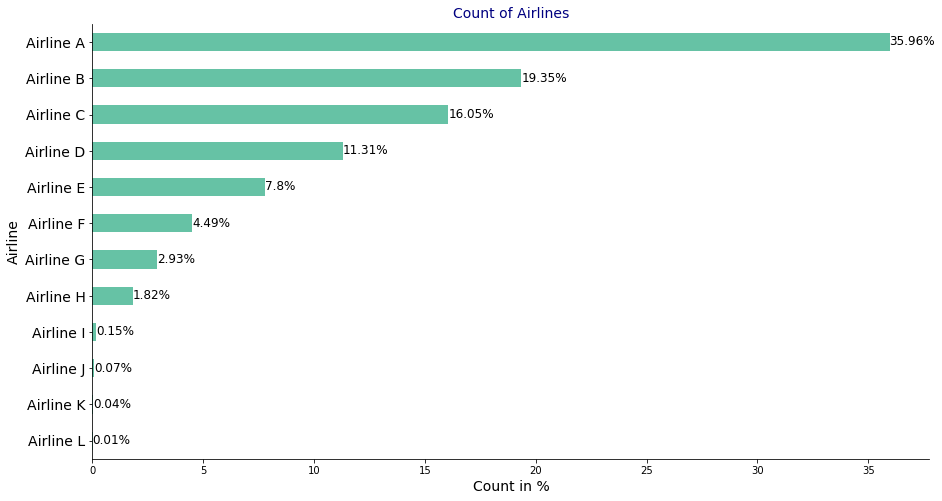

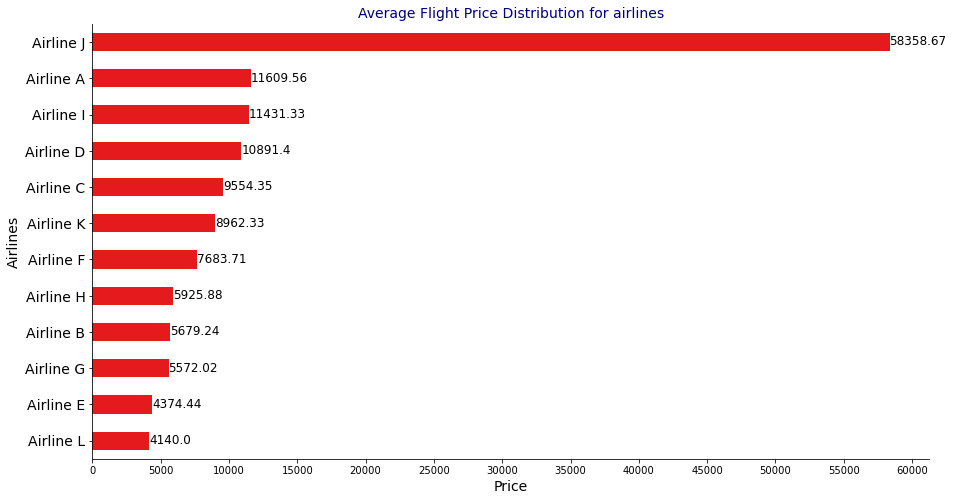

In [32]:
# getting relative count of different airlines
plt.figure(figsize=(15,8))
s = (data.Airline.value_counts(normalize=True)*100).sort_values().plot.barh(cmap='Set2')
sns.despine()

plt.xlabel("Count in %", size=14)
plt.ylabel("Airline", size=14,)
plt.yticks(size=14)
plt.title("Count of Airlines", size=14,  color='navy')

# the following loop creates annotations of the value for each bar in the plot
for rect in s.patches:    
                plt.text(rect.get_width(), 
                        rect.get_y() + rect.get_height()/3., 
                        str(round(rect.get_width(),2))+'%', 
                        fontsize=12 )
        
        

# analysing price based upon categories of Airline
plt.figure(figsize=(15,8))
t = data.groupby('Airline').mean()['Price'].sort_values().plot.barh(cmap='Set1')
sns.despine()

plt.xlabel("Price", size=14)
plt.ylabel("Airlines", size=14)
plt.xticks(np.arange(0,65000, 5000))
plt.yticks(size=14)
plt.title("Average Flight Price Distribution for airlines", size=14, color='navy')

# the following loop creates annotations of the value for each bar in the plot
for rect in t.patches:    
                plt.text(rect.get_width(), 
                        rect.get_y() + rect.get_height()/3., 
                        str(round(rect.get_width(),2)), 
                        fontsize=12 )

plt.show()

### Insights:
- **Airline A is the most popular airline**, among the 12 airlines, with almost 36% flights belonging to Airline A.
- The second airline having most flights is Airline B, which has almost half the number of flights as that of Airline A. **70% of the flights belong to the top three airlines which are Airline A, B and C**.
- **Airline J, K and L** have the least flights forming only 0.07%, 0.04% and 0.01% of the flights respectively.
- One remarkable observation is that, even though **Airline J** is amongst the 3 least popular airlines contributing only 6 flights, **the average flight price for this airline is the highest, which is almost 58000**.
- Other than Airline J, **all other airlines have average flight prices below 15000**, with the second highest being Airline A with average flight price of nearly 12000.

## The most popular source, destination and route for flights.

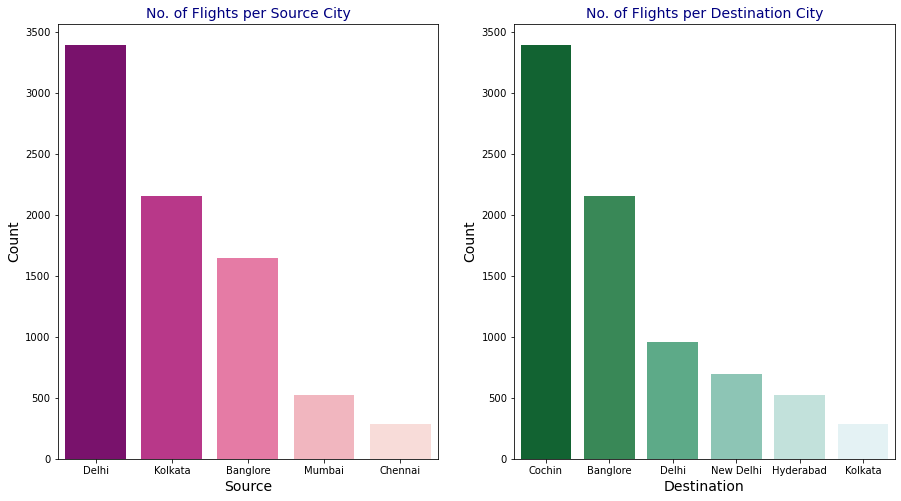

Most popular route for flights:
DEL → BOM → COK    1784
BLR → DEL          1172
CCU → BOM → BLR     752
CCU → BLR           537
BOM → HYD           468
Name: Route, dtype: int64


In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

sns.countplot(x=data.Source, order=data.Source.value_counts().sort_values(ascending=False).index, palette='RdPu_r'  ,ax=ax1)
ax1.set_xlabel("Source", size=14)
ax1.set_ylabel("Count", size=14)
ax1.set_title("No. of Flights per Source City", size=14, color='navy')

sns.countplot(x=data.Destination, order=data.Destination.value_counts().sort_values(ascending=False).index, palette='BuGn_r',ax=ax2)
ax2.set_xlabel("Destination", size=14)
ax2.set_ylabel("Count", size=14)
ax2.set_title("No. of Flights per Destination City", size=14, color='navy')

plt.show()

print("Most popular route for flights:")
print(data.Route.value_counts().sort_values(ascending=False).head())

### Insights:
- Maximum number of flights originate from **Delhi**, whereas **Chennai** is the source city for least flights (less than 300)
- The most popular destination city is **Cochin** amongst the 6 cities and **Kolkata** is the destination of less than 300 flights which is the least.
- There are many flights from Delhi to Cochin with one stop at Mumbai.

## Analyzing the price feature based upon the source and destination of flight

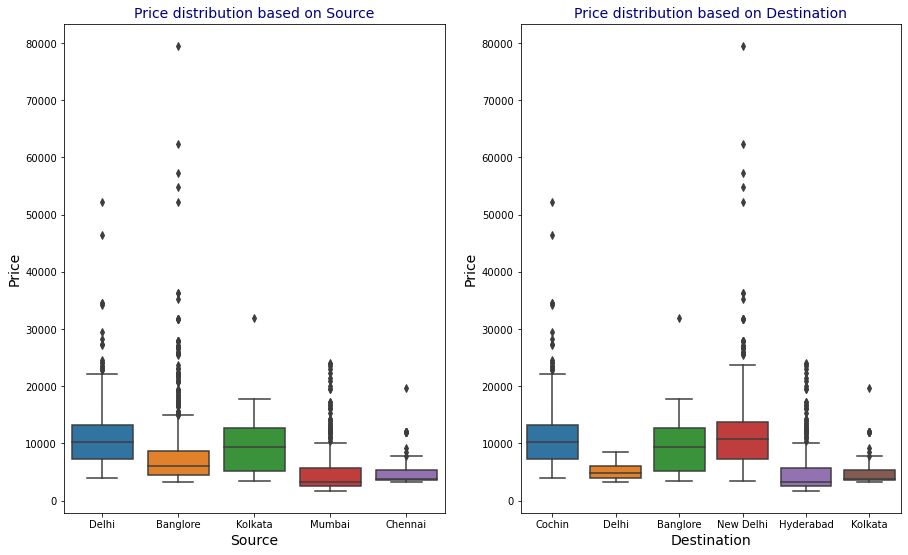

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,9))

sns.boxplot(x= data['Source'], y= data['Price'], ax=ax1)
ax1.set_xlabel("Source", size=14)
ax1.set_ylabel("Price", size=14)
ax1.set_title("Price distribution based on Source", size=14, color='navy')

sns.boxplot(x = data['Destination'], y = data['Price'], ax=ax2)
ax2.set_xlabel("Destination", size=14)
ax2.set_ylabel("Price", size=14)
ax2.set_title("Price distribution based on Destination", size=14, color='navy')

plt.show()

### Insights:
**Source:**
- The flights originating from **Delhi** have a higher price range as compared to other source cities.
- The price distribution of flights having source city **Bangalore** has the highest number of and also largest outliers indicating that some flights orginating from Bangalore have higher price than 75th percentile of flights from this city.
- Price of flights from source city **Kolkata** have the highest interquartile range, and also only one outlier.

**Destination:**
- Flights having **Cochin** and **New Delhi** has their destination have higher price range amongst others, with flights going to **New Delhi** being costlier amongst these two.
- Flights to **New Delhi** have the largest outliers in flight ticket price.
- Price of flights to **Delhi** has a clean distribution with no extreme values.
- The cost of flights **Kolkata** has smallest distribution with some outlying values, and **Hyderabad** has the least minimum flight cost amongst other destinations.


- The distributions of prices can also be affected by the number of flights.

## Distribution of price based on the total number of stops in the flight route

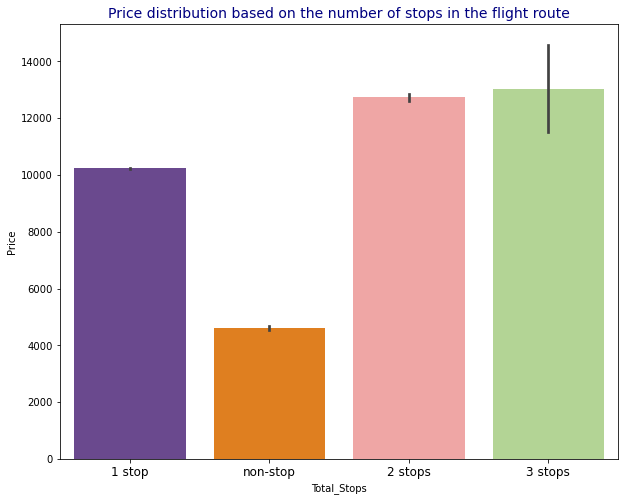

In [35]:
plt.figure(figsize=(10,8))
sns.barplot(x=data.Total_Stops, y=data.Price, estimator=np.median, palette='Paired_r')
plt.xticks(size=12)
plt.title("Price distribution based on the number of stops in the flight route", color="navy", size=14)
plt.show()

### Insights:
- The price of the flight clearly increases with an increase in the total number of stops in the flight journey. 

## Analyzing the Journey Month and it's relation with the price of the ticket

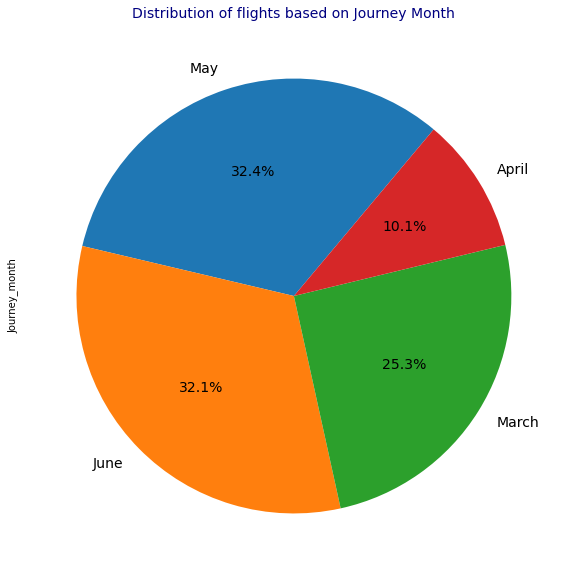

In [36]:
data.Journey_month.value_counts().plot.pie(startangle=50, 
                                           figsize=(10,10),
                                           autopct="%0.1f%%",
                                           labels = ['May', 'June', 'March', 'April'],
                                           textprops={'size':14})

plt.title('Distribution of flights based on Journey Month', size=14, color='navy' )
plt.show()

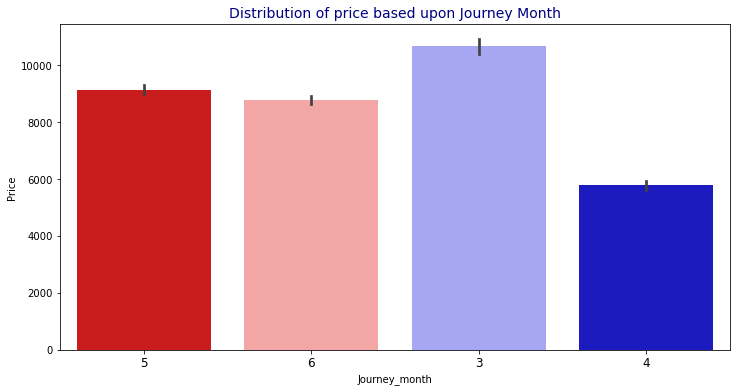

In [37]:
plt.figure(figsize=(12,6))
sns.barplot(x=data.Journey_month, y=data.Price, palette='seismic_r', 
            order=data.Journey_month.value_counts().sort_values(ascending=False).index)
plt.xticks(size=12)
plt.title("Distribution of price based upon Journey Month", color='navy', size=14)
plt.show()

### Insights:
- The month of May is most popular and has highest number of flights, followed by June whereas the month of April has lowest distribution of flights.
- The price of flight tickets is highest during March, and lowest during April which means that airlines make a larger profit during March, and not during May which has highest number of numbers.

## Checking the distribution of flight ticket price based upon flight departure hour and arrival hour.

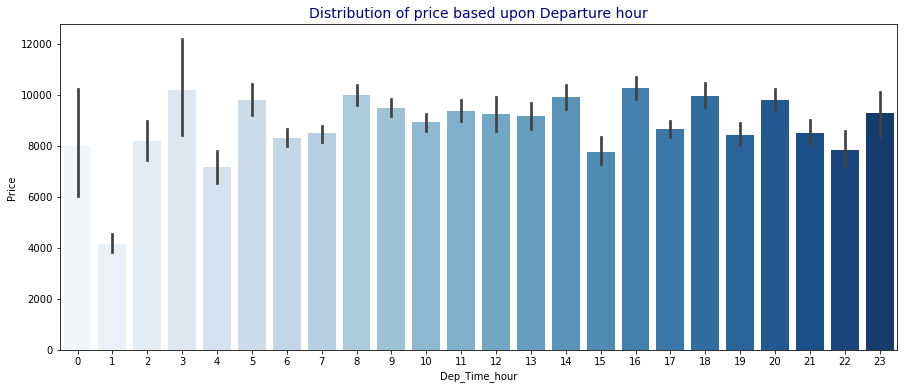

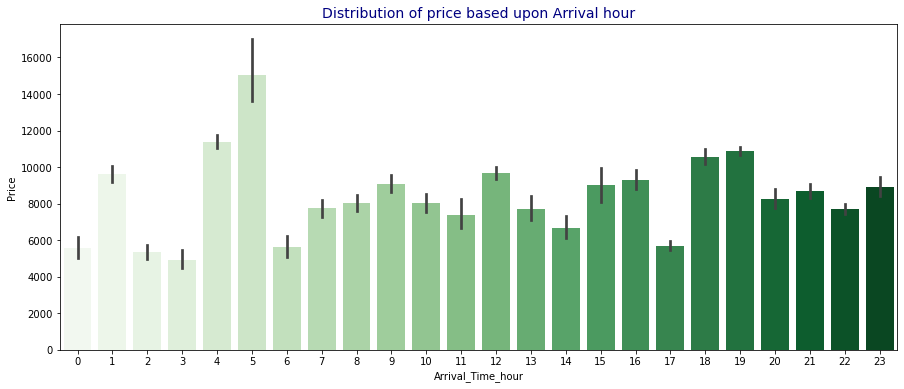

In [38]:
# for departure hour
plt.figure(figsize=(15,6))
sns.barplot(x='Dep_Time_hour', y='Price', data=data, palette="Blues")
plt.title("Distribution of price based upon Departure hour", color='navy', size=14)

# for arrival hour
plt.figure(figsize=(15,6))
sns.barplot(x='Arrival_Time_hour', y='Price', data=data, palette="Greens")
plt.title("Distribution of price based upon Arrival hour", color='navy', size=14)

plt.show()

#### Insights:
- Price as per departure hour is almost evenly distributed with slightly higher range in the midnight to early morning hours from 00:00 hours to 03:00 hours
- Flights arriving at 5 o'clocl in the morning have higher price than any other flight based on Arrival hour.

## Analysis of Additional_info feature

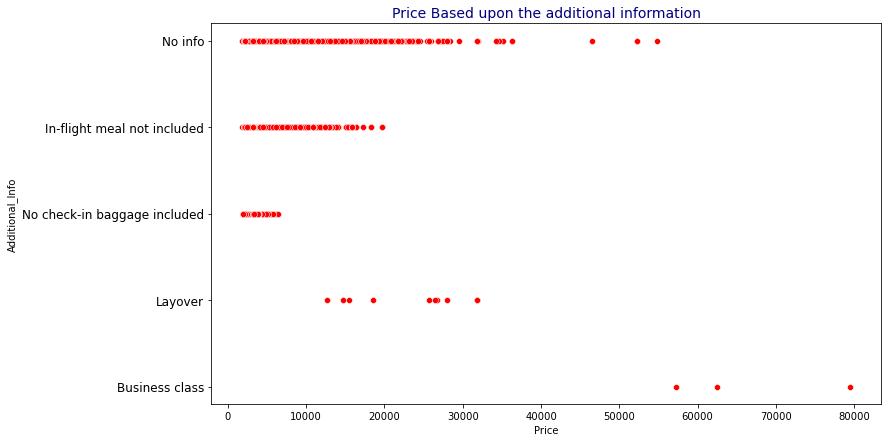

In [39]:
plt.figure(figsize=(12,7))
sns.scatterplot(y=data.Additional_Info, x=data.Price, color='red')
plt.yticks(size=12)
plt.title("Price Based upon the additional information", color='navy', size=14)
plt.show()

### Insights:
- Most of the flights have no additional information available.
- Flights which do not provide inflight meal is mostly priced below 20000
- Flights which do not include check-in baggage have ticket prices lower than 7000
- There are only 3 Business class flights and all of them are priced at more than 55000, thus acting as outliers here.

## Checking the details of flights having the smallest and the largest price

In [40]:
# data of cheapest flights
data.sort_values(by="Price").head(10)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_in_minutes
6763,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No info,1759,27,3,22,45,0,10,85
5176,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No info,1759,3,4,22,45,0,15,90
557,Airline A,Mumbai,Hyderabad,BOM → HYD,non-stop,In-flight meal not included,1840,27,3,2,55,4,25,90
5687,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,21,5,5,45,7,15,90
7970,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,3,4,13,15,14,45,90
5331,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,12,5,22,45,0,15,90
5386,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,15,6,13,15,14,45,90
2612,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,9,5,22,45,0,15,90
4704,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,6,6,22,45,0,15,90
7929,Airline E,Mumbai,Hyderabad,BOM → HYD,non-stop,No check-in baggage included,1965,21,5,13,15,14,45,90


### Insights:
- The cheapest flight is priced at **1759** and is from **Mumbai to Hyderabad** with **0 stops** and **duration of 85-90 minutes**. Also this flight is under **Airline E**.
- The top 10 cheapest flights are from Mumbai to Hyderabad from Airline E, and all have duration 90 minutes and zero stops.

In [41]:
# data of costliest flights
data.sort_values(by="Price", ascending=False).head(10)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_in_minutes
1870,Airline J,Banglore,New Delhi,BLR → BOM → DEL,1 stop,Business class,79512,1,3,5,45,11,25,340
3343,Airline J,Banglore,New Delhi,BLR → BOM → DEL,1 stop,Business class,62427,1,3,5,45,12,25,400
6894,Airline J,Banglore,New Delhi,BLR → MAA → DEL,1 stop,Business class,57209,1,3,9,45,14,25,280
3241,Airline A,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,54826,18,3,22,50,5,5,375
2368,Airline J,Delhi,Cochin,DEL → ATQ → BOM → COK,2 stops,No info,52285,6,3,20,5,4,25,500
5734,Airline J,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,52229,1,3,5,45,10,45,300
1271,Airline J,Delhi,Cochin,DEL → ATQ → BOM → COK,2 stops,No info,46490,3,3,20,5,4,25,500
7412,Airline A,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,36235,1,3,14,5,21,20,435
4412,Airline A,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,36235,1,3,14,5,19,10,305
746,Airline A,Banglore,New Delhi,BLR → BOM → DEL,1 stop,No info,35185,1,3,18,40,0,45,365


### Insights:
- Out of the top 10 cosliest flight tickets, 8 are **from Bangalore to New Delhi, with one stop.**
- The top **three most expensive** flight tickets are of **Business Class.**
- The 10 most expensive tickets were of flights that were more than **300 minutes in duration**, all belonging to the **month of March.**

## Correlation analysis

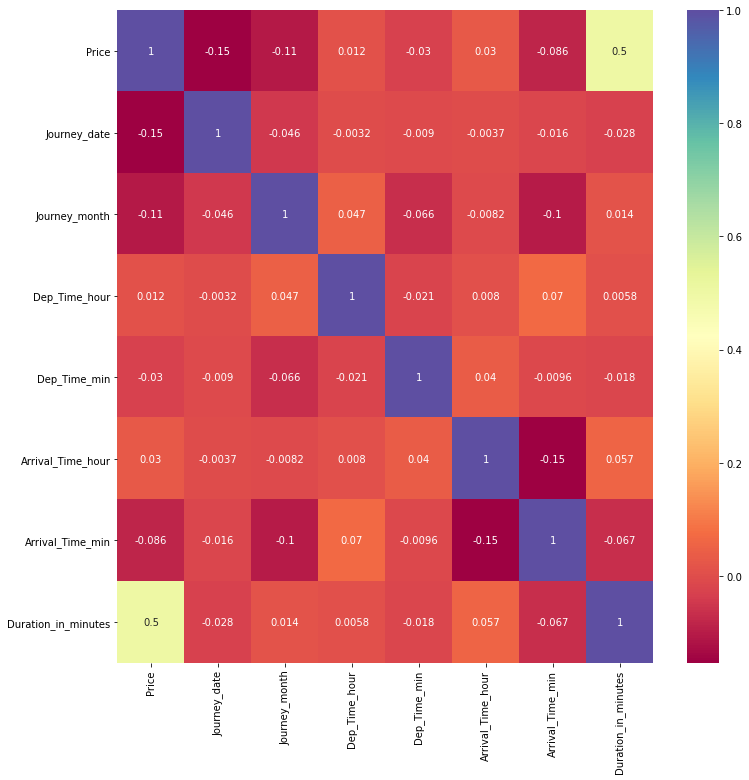

In [42]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), annot=True, cmap="Spectral")
plt.show()

## Preparing the data for machine learning model

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8011 entries, 0 to 8011
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              8011 non-null   object
 1   Source               8011 non-null   object
 2   Destination          8011 non-null   object
 3   Route                8011 non-null   object
 4   Total_Stops          8011 non-null   object
 5   Additional_Info      8011 non-null   object
 6   Price                8011 non-null   int64 
 7   Journey_date         8011 non-null   int64 
 8   Journey_month        8011 non-null   int64 
 9   Dep_Time_hour        8011 non-null   int64 
 10  Dep_Time_min         8011 non-null   int64 
 11  Arrival_Time_hour    8011 non-null   int64 
 12  Arrival_Time_min     8011 non-null   int64 
 13  Duration_in_minutes  8011 non-null   int64 
dtypes: int64(8), object(6)
memory usage: 1.2+ MB


In [44]:
data.Route.nunique()

122

### We drop the route column, since it has too many unique values and it won't be practical to encode it.

In [45]:
data.drop('Route', axis=1, inplace=True)

### Converting Total_Stops to numeric data using Label encoding

In [46]:
data.Total_Stops.unique()

array(['1 stop', 'non-stop', '2 stops', '3 stops'], dtype=object)

In [47]:
stops_dict = {'non-stop':0,
             '1 stop':1,
             '2 stops':2,
             '3 stops':3,
             '4 stops':4}

data['Total_Stops'] = data['Total_Stops'].map(stops_dict)

In [48]:
data['Total_Stops'].unique()

array([1, 0, 2, 3], dtype=int64)

### Converting the categorical features into numerical by using one-hot ecoding

In [49]:
airlines = pd.get_dummies(data['Airline'], drop_first=True)
airlines.head()

,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H,Airline I,Airline J,Airline K,Airline L
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [50]:
source = pd.get_dummies(data['Source'], prefix='Source', drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,1,0,0
1,0,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0


In [51]:
Destination = pd.get_dummies(data['Destination'], prefix='Destination', drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [52]:
Additional_Info = pd.get_dummies(data['Additional_Info'], drop_first=True)
Additional_Info.head()

,In-flight meal not included,Layover,No check-in baggage included,No info
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
4,1,0,0,0


In [53]:
train_data = pd.concat([data, airlines, source, Destination, Additional_Info], axis=1)
train_data.drop(['Airline', 'Source', 'Destination', 'Additional_Info'], axis=1, inplace=True)
train_data.head()

,Total_Stops,Price,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_in_minutes,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H,Airline I,Airline J,Airline K,Airline L,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,In-flight meal not included,Layover,No check-in baggage included,No info
0,1,7480,12,6,20,40,9,25,765,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,8016,18,6,18,55,22,0,185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,8879,18,5,3,50,19,15,925,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,1,9663,6,5,20,0,8,15,735,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,1,9663,9,5,6,30,12,0,330,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


The training data is now ready to be used for training the machine learning models.

### Splitting the training data into train and validation datasets

In [54]:
X = train_data.drop("Price", axis=1)
y = train_data["Price"]

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

## Machine Learning models

###  Linear Regression

In [56]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_val)

print("Results for Linear Regression Model:")
print(50 * '-')
print('RMSE:', np.sqrt(mse(y_val, lr_predictions)))
print("R-squared: ", r2_score(y_val, lr_predictions))

Results for Linear Regression Model:
--------------------------------------------------
RMSE: 2611.953020083325
R-squared:  0.6777678753012863


### Random Forest Regressor

In [57]:
tuned_parameters = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'min_samples_split': [2, 5, 10, 15,50], 
                 'min_samples_leaf': [1, 2, 4, 10], }

rf_model = RandomizedSearchCV(RandomForestRegressor(), tuned_parameters, n_iter = 50, 
                                      scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
rf_model.fit(X_train, y_train)

print(rf_model.best_estimator_)
print(rf_model.best_params_)
print()

rf_predictions = rf_model.predict(X_val)

print("Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", np.sqrt(mse(y_val, rf_predictions)))
print("R-squared: ", r2_score(y_val, rf_predictions))

RandomForestRegressor(n_estimators=900)
{'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1}

Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  1611.0939718792956
R-squared:  0.8774029958006249


### XGBoost Regressor

In [58]:
xgb_model = XGBRegressor(objective='reg:squarederror',n_jobs=-1,subsample = 0.7, scale_pos_weight= 5, 
                        reg_lambda= 4, n_estimators = 110, min_child_weight= 13, max_depth = 12, 
                        learning_rate= 0.1, colsample_bytree = 0.9, colsample_bynode= 0.9)

xgb_model.fit(X_train,y_train)

xgb_predictions  = xgb_model.predict(X_val)

print("Results for XGBRegressor Model:")
print(50 * '-')
print("Root mean squared error: ", np.sqrt(mse(y_val, xgb_predictions)))
print("R-squared: ", r2_score(y_val, xgb_predictions))

Results for XGBRegressor Model:
--------------------------------------------------
Root mean squared error:  1590.7951370555004
R-squared:  0.8804728341632229


**XGBRegressor has the lowest RMSE, so we choose this model.**


# TEST DATA CLEANING AND EVALUATION

In [59]:
# reading the test dataset
test_data = pd.read_csv('./data/test.csv')
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Airline B,27-03-2019,Delhi,Cochin,DEL → HYD → COK,04:55,16:10,11h 15m,1 stop,No info
1,Airline E,27-05-2019,Kolkata,Banglore,CCU → BLR,22:20,28-05-2020 00:40,2h 20m,non-stop,No info
2,Airline C,06-06-2019,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,20:25,14h 35m,2 stops,No info
3,Airline A,06-03-2019,Banglore,New Delhi,BLR → MAA → DEL,09:45,14:25,4h 40m,1 stop,No info
4,Airline B,15-06-2019,Delhi,Cochin,DEL → BOM → COK,16:00,16-06-2020 01:30,9h 30m,1 stop,No info


In [60]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [61]:
test_data.shape

(2671, 10)

### Feature engineering and data preprocessing on Test Data

**"Date_of_Journey" Feature**

In [62]:
test_data['Date_of_Journey'] = pd.to_datetime(test_data['Date_of_Journey'], dayfirst=True)
test_data['Journey_date']  = test_data['Date_of_Journey'].dt.day
test_data['Journey_month'] = test_data['Date_of_Journey'].dt.month
test_data['Journey_year']  = test_data['Date_of_Journey'].dt.year
test_data.drop(['Date_of_Journey', 'Journey_year'], axis=1, inplace=True)

**"Total_Stops" Feature**

In [63]:
test_data['Total_Stops'] = test_data['Total_Stops'].map(stops_dict)
test_data['Total_Stops'].unique()

array([1, 0, 2, 3, 4], dtype=int64)

**Extracting hour and minutes from departure time and arrival time**

In [64]:
extract_hour_minutes(test_data, 'Dep_Time')

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min
0,Airline B,Delhi,Cochin,DEL → HYD → COK,16:10,11h 15m,1,No info,27,3,4,55
1,Airline E,Kolkata,Banglore,CCU → BLR,28-05-2020 00:40,2h 20m,0,No info,27,5,22,20
2,Airline C,Kolkata,Banglore,CCU → IXR → DEL → BLR,20:25,14h 35m,2,No info,6,6,5,50
3,Airline A,Banglore,New Delhi,BLR → MAA → DEL,14:25,4h 40m,1,No info,6,3,9,45
4,Airline B,Delhi,Cochin,DEL → BOM → COK,16-06-2020 01:30,9h 30m,1,No info,15,6,16,0


In [65]:
# here the arrival_time feature contains date first, so we need to extract the time properly
def split(a):
    b = a.split(" ")
    if len(b) == 2:
        return b[1]
    else:
        return b[0]

test_data['Arrival_Time'] = test_data['Arrival_Time'].apply(split)

extract_hour_minutes(test_data, 'Arrival_Time')


,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,Airline B,Delhi,Cochin,DEL → HYD → COK,11h 15m,1,No info,27,3,4,55,16,10
1,Airline E,Kolkata,Banglore,CCU → BLR,2h 20m,0,No info,27,5,22,20,0,40
2,Airline C,Kolkata,Banglore,CCU → IXR → DEL → BLR,14h 35m,2,No info,6,6,5,50,20,25
3,Airline A,Banglore,New Delhi,BLR → MAA → DEL,4h 40m,1,No info,6,3,9,45,14,25
4,Airline B,Delhi,Cochin,DEL → BOM → COK,9h 30m,1,No info,15,6,16,0,1,30


**Converting the flight duration to minutes**

In [66]:
test_data['Duration_in_minutes'] = test_data.Duration.apply(convert_duration_to_min)
test_data[['Duration', 'Duration_in_minutes']].head(10)

,Duration,Duration_in_minutes
0,11h 15m,675
1,2h 20m,140
2,14h 35m,875
3,4h 40m,280
4,9h 30m,570
5,20h 15m,1215
6,13h 30m,810
7,8h 10m,490
8,18h 50m,1130
9,1h 30m,90


In [67]:
test_data.drop('Duration', axis=1, inplace=True)

**Feature engineering on "Additional_Info" column**

In [68]:
test_data.Additional_Info.value_counts()

No info                         2094
In-flight meal not included      490
No check-in baggage included      71
1 Long layover                    10
Change airports                    5
Business class                     1
Name: Additional_Info, dtype: int64

In [69]:
test_data.Additional_Info = test_data.Additional_Info.apply(lambda x : x.replace("1 Long layover", "Layover"))

test_data.Additional_Info = test_data.Additional_Info.apply(lambda x : x.replace("Change airports", "No info"))

test_data.Additional_Info.value_counts()

No info                         2099
In-flight meal not included      490
No check-in baggage included      71
Layover                           10
Business class                     1
Name: Additional_Info, dtype: int64

**Dropping the Route feature**

In [70]:
test_data.drop('Route', axis=1, inplace=True)

**Converting the categorical features into numerical by using one-hot ecoding**

In [71]:
test_data.Airline.value_counts()

Airline A    968
Airline B    503
Airline C    465
Airline D    290
Airline E    193
Airline F    119
Airline G     84
Airline H     48
Airline I      1
Name: Airline, dtype: int64

The airline feature in test dataset has some missing levels. We will have to create a zero matrix for these, after creating the dummy variables

In [72]:
test_airlines = pd.get_dummies(test_data['Airline'], drop_first=True)
test_airlines

,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H,Airline I
0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2666,0,1,0,0,0,0,0,0
2667,0,0,0,0,0,1,0,0
2668,0,0,0,0,0,0,0,0
2669,0,0,0,0,0,0,0,0


In [73]:
# for missing features in airline:
feature_difference = set(airlines) - set(test_airlines)
feature_difference_df = pd.DataFrame(data=np.zeros((test_airlines.shape[0], len(feature_difference)), dtype='int64'), 
                                     columns = list(feature_difference))
test_airlines = test_airlines.join(feature_difference_df)
test_airlines.fillna(value = 0, inplace=True)
new_features = ['Airline K', 'Airline L', 'Airline J']
for i in new_features:
    test_airlines[i] = test_airlines[i].astype('int')

In [74]:
# getting dummies for source, destination and additional info features

source = pd.get_dummies(test_data['Source'], prefix='Source', drop_first=True)
Destination = pd.get_dummies(test_data['Destination'], prefix='Destination', drop_first=True)
Additional_Info = pd.get_dummies(test_data['Additional_Info'], drop_first=True)

test_data = pd.concat([test_data, test_airlines, source, Destination, Additional_Info], axis=1)


In [75]:
test_data.drop(['Airline', 'Source', 'Destination', 'Additional_Info'], axis=1, inplace=True)
test_data.head()

,Total_Stops,Journey_date,Journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_in_minutes,Airline B,Airline C,Airline D,Airline E,Airline F,Airline G,Airline H,Airline I,Airline K,Airline J,Airline L,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,In-flight meal not included,Layover,No check-in baggage included,No info
0,1,27,3,4,55,16,10,675,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,0,27,5,22,20,0,40,140,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,2,6,6,5,50,20,25,875,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1,6,3,9,45,14,25,280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,1,15,6,16,0,1,30,570,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


#  Predictions using test data

In [76]:
X_test = pd.DataFrame(data = test_data, columns=X_train.columns.to_list())
X_test.columns.shape

(32,)

In [77]:
X_val.columns.shape

(32,)

In [78]:
# obtaining predictions for the test data using our winning model
y_pred = xgb_model.predict(X_test)
y_pred

array([ 5602.849 ,  3991.2842, 11878.178 , ..., 13320.227 ,  4730.2285,
        6676.559 ], dtype=float32)

In [79]:
y_pred.shape

(2671,)

In [80]:
submission_file_Samantha = pd.DataFrame(y_pred, columns = ['Price'])

submission_file_Samantha.head(10)

,Price
0,5602.849121
1,3991.284180
2,11878.177734
3,15388.434570
4,6251.508301
5,9078.188477
6,6009.527832
7,9991.775391
8,13425.030273
9,4456.141602


In [81]:
submission_file_Samantha.to_csv('submission_file_Samantha.csv', index=False)